# IMPORTING THE LIBRARIES

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm
import torch

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [2]:
# Pretty display for notebooks
%matplotlib inline

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Use CPU
    print("Using CPU")

Using GPU: NVIDIA GeForce GTX 1650


# Defining the train,test and model directories

We will create the directories for train,test and model training paths if not present

In [4]:
DATA_DIR = "state-farm-distracted-driver-detection/imgs/"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [5]:
# import os

# DATA_DIR = "state-farm-distracted-driver-detection/imgs/"
# TEST_DIR = os.path.join(DATA_DIR, "test")

# # Get absolute path and check existence
# abs_test_dir = os.path.abspath(TEST_DIR)
# print(f"Absolute TEST_DIR: {abs_test_dir}")
# print(f"Exists: {os.path.exists(abs_test_dir)}")


In [6]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Data Preparation

We will create a csv file having the location of the files present for training and test images and their associated class if present so that it is easily traceable.

In [7]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   22424 non-null  object
 1   ClassName  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [9]:
data_train['ClassName'].value_counts()

ClassName
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64

In [10]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,state-farm-distracted-driver-detection/imgs/tr...,c0
freq,1,2489


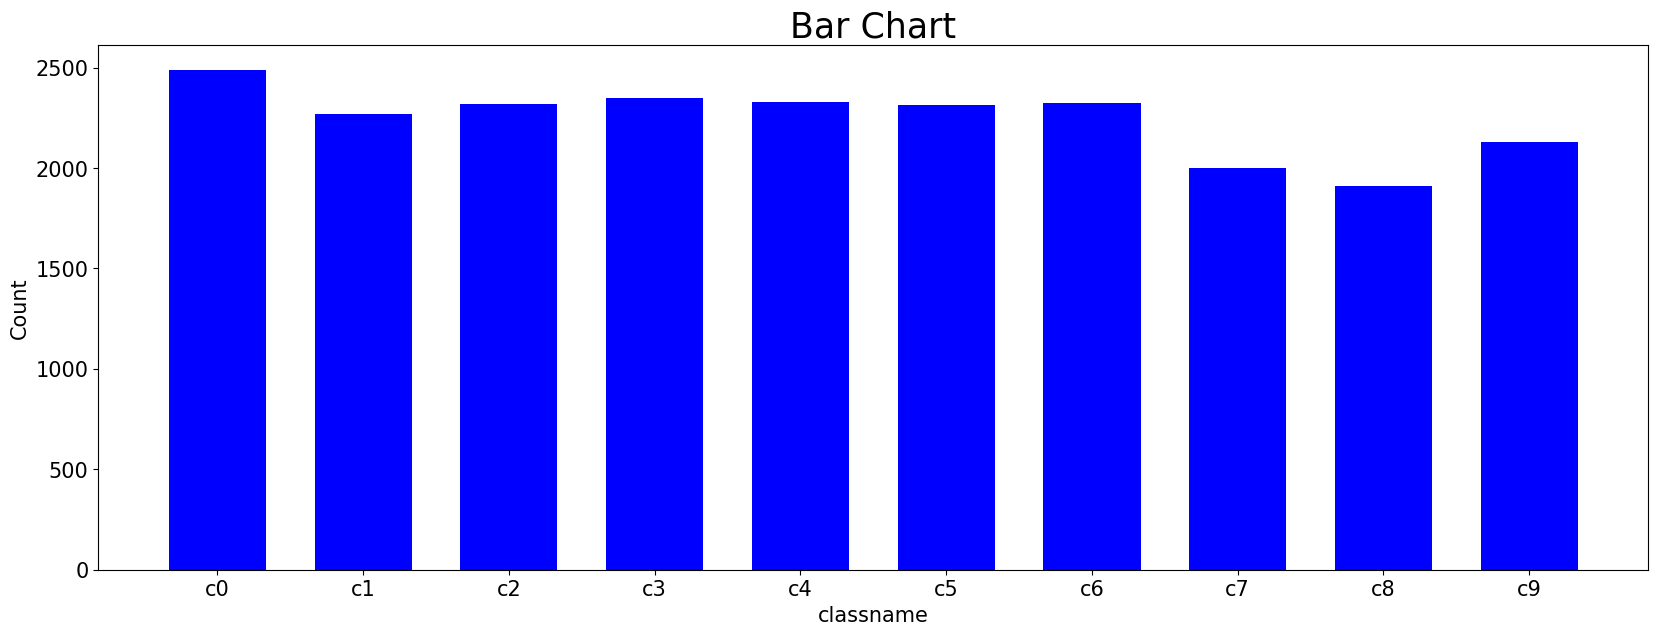

In [11]:


nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [12]:
data_test.head()

,FileName,ClassName
0,state-farm-distracted-driver-detection/imgs/te...,test
1,state-farm-distracted-driver-detection/imgs/te...,test
2,state-farm-distracted-driver-detection/imgs/te...,test
3,state-farm-distracted-driver-detection/imgs/te...,test
4,state-farm-distracted-driver-detection/imgs/te...,test


In [13]:
data_test.shape

(79726, 2)

## Observation:
1. There are total 22424 training samples
2. There are total 79726 testing samples
3. The training dataset is equally balanced to a great extent and hence we need not do any downsampling of the data

## Converting into numerical values

In [14]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c5': 0, 'c8': 1, 'c1': 2, 'c3': 3, 'c0': 4, 'c7': 5, 'c2': 6, 'c4': 7, 'c6': 8, 'c9': 9}


C:\Users\chiac\AppData\Local\Temp\ipykernel_21868\1324950157.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['ClassName'].replace(labels_id,inplace=True)
C:\Users\chiac\AppData\Local\Temp\ipykernel_21868\1324950157.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train['ClassN

In [15]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [16]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


## Splitting into Train and Test sets

In [17]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

### Converting into 64*64 images 
You can substitute 64,64 to 224,224 for better results only if ram is >32gb

In [18]:

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64,64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [19]:

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5


100%|██████████| 17939/17939 [00:38<00:00, 460.36it/s]


In [20]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5


100%|██████████| 4485/4485 [00:09<00:00, 455.90it/s]


In [21]:
##takes too much ram 
## run this if your ram is greater than 16gb 
test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5 

100%|██████████| 79726/79726 [02:54<00:00, 457.79it/s]


# Defining the Model

In [22]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

c:\Users\chiac\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,366 (18.28 MB)

 Trainable params: 4,791,366 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# pip install pydot

In [24]:
plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.keras")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_freq='epoch')
callbacks_list = [checkpoint]

In [27]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3862 - loss: 1.6475
Epoch 1: val_accuracy improved from -inf to 0.90524, saving model to c:\Users\chiac\Desktop\FYP_Phase1\CNN\model\self_trained\distracted-01-0.91.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 65s 142ms/step - accuracy: 0.3867 - loss: 1.6462 - val_accuracy: 0.9052 - val_loss: 0.3077
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9059 - loss: 0.3062
Epoch 2: val_accuracy improved from 0.90524 to 0.94983, saving model to c:\Users\chiac\Desktop\FYP_Phase1\CNN\model\self_trained\distracted-02-0.95.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step - accuracy: 0.9059 - loss: 0.3060 - val_accuracy: 0.9498 - val_loss: 0.1653
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9564 - loss: 0.1449
Epoch 3: val_accuracy improved from 0.94983 to 0.97436, saving model to c:\Users\chiac\Desktop\FYP_Phase1\CNN\model\self_trained\distracted-03-0.97.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 63s 140m

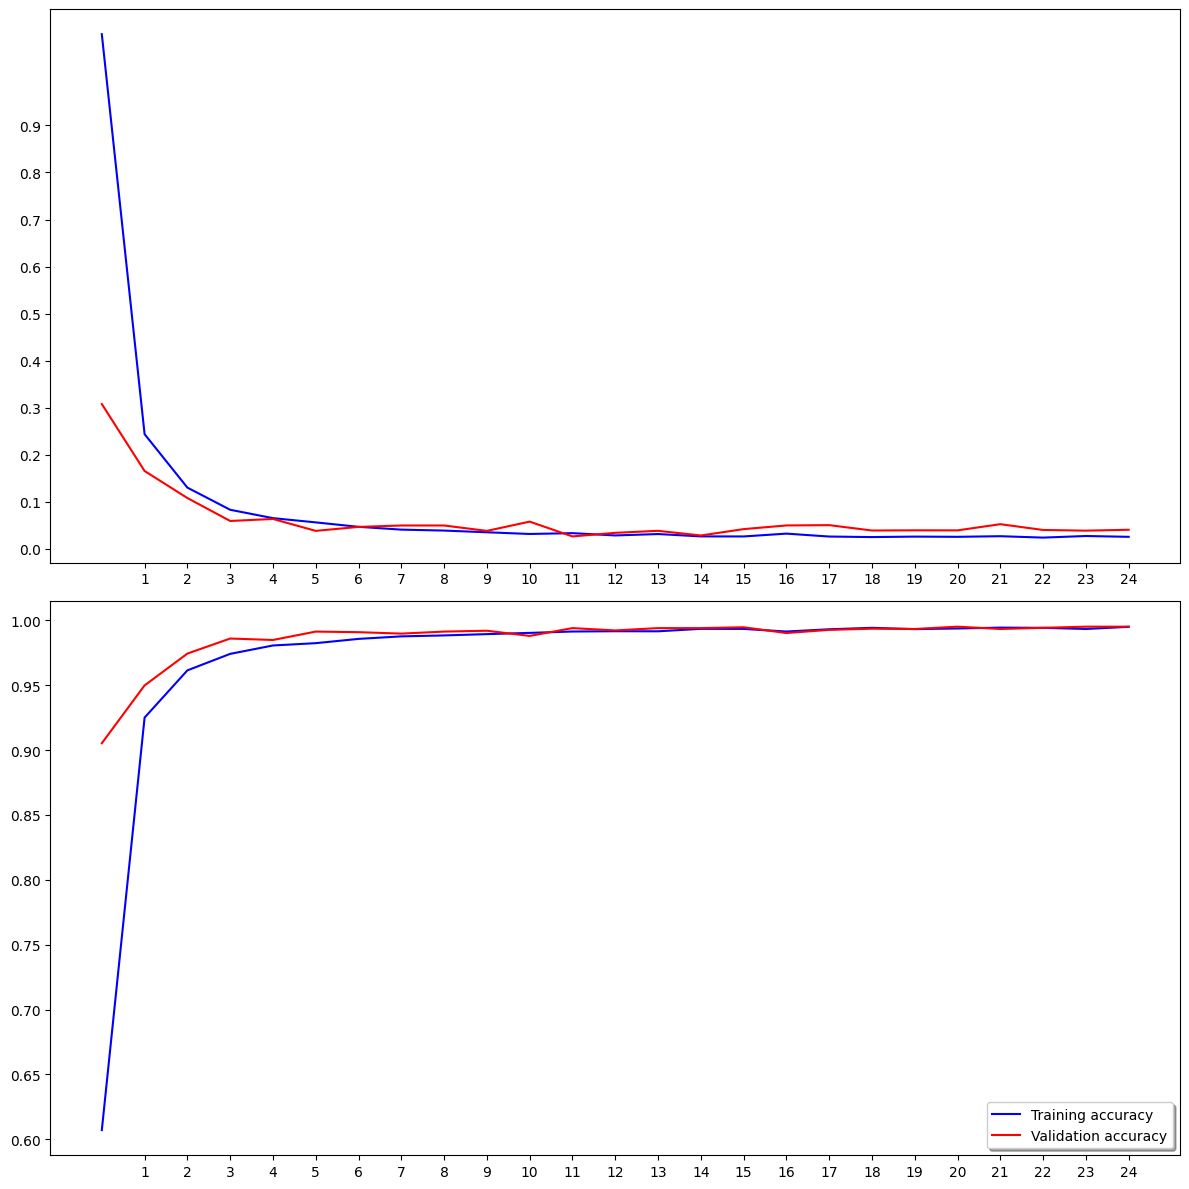

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis

Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created 

In [29]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig


In [30]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)


In [31]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
ypred = model.predict(valid_tensors)

141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


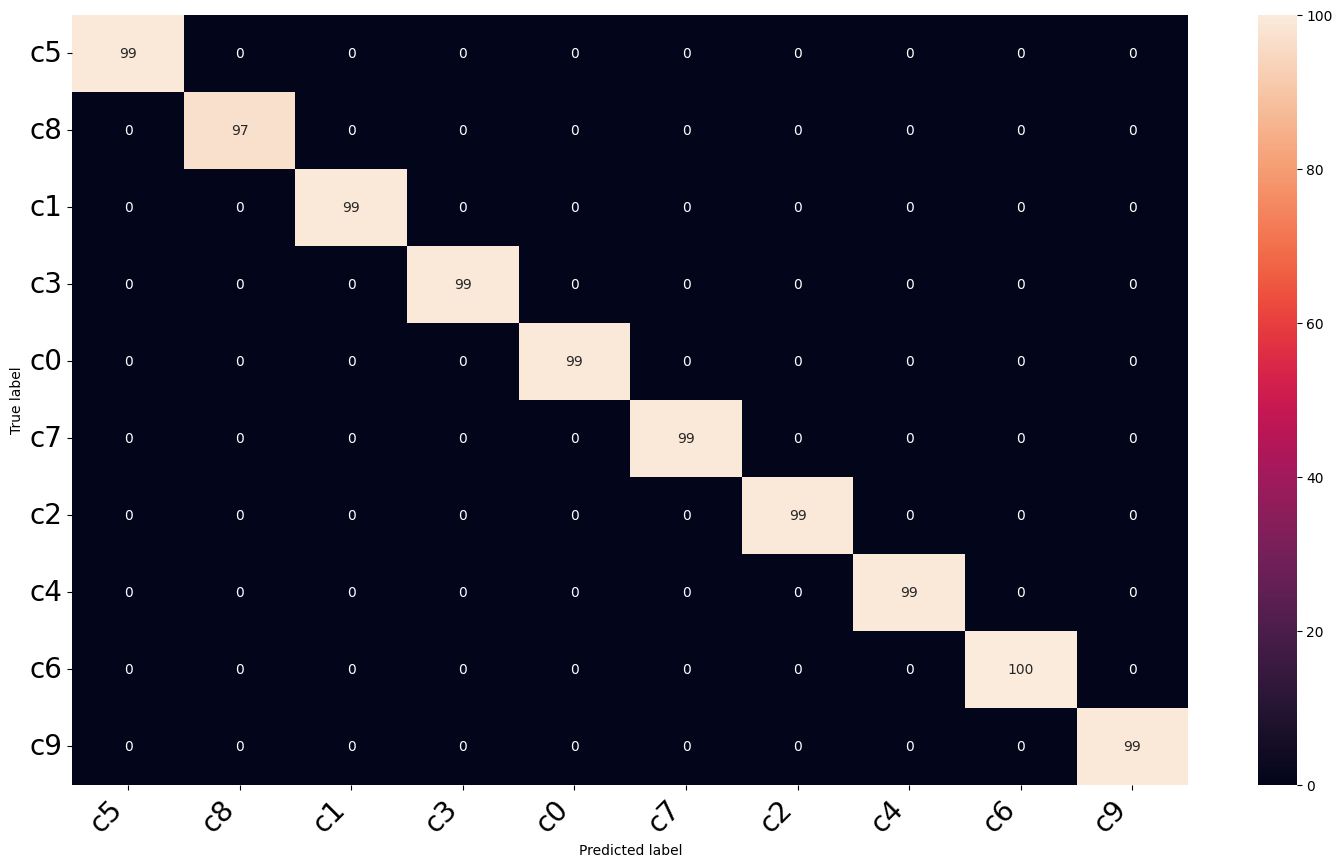

In [32]:
print_heatmap(ytest,ypred,class_names)

## Precision Recall F1 Score

In [33]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [34]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.995095
Precision: 0.995112
Recall: 0.995095
F1 score: 0.995090


In [56]:
import cv2
import tensorflow as tf
import numpy as np

# Load the trained model
MODEL_PATH = "model/self_trained/distracted-16-0.99.keras"  # Update with your model's path
model = tf.keras.models.load_model(MODEL_PATH)

# Define class labels
class_labels = [
    "Normal driving",
    "Texting - right",
    "Talking on the phone - right",
    "Texting - left",
    "Talking on the phone - left",
    "Operating the radio",
    "Drinking",
    "Reaching behind",
    "Hair and makeup",
    "Talking to passenger",
]

# Open the webcam
cap = cv2.VideoCapture(0)  # Replace 0 with the appropriate camera index

if not cap.isOpened():
    print("Unable to access the camera")
    exit()

while True:
    # Capture a frame
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Preprocess the frame for the model
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    resized_frame = cv2.resize(frame_rgb, (64, 64))  # Resize to match model input
    normalized_frame = resized_frame / 255.0  # Normalize pixel values
    input_frame = np.expand_dims(normalized_frame, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(input_frame)
    predicted_class = np.argmax(predictions[0])
    predicted_label = class_labels[predicted_class]

    # Add prediction text to the frame
    cv2.putText(
        frame,
        f"Prediction: {predicted_label}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
        cv2.LINE_AA,
    )

    # Display the frame
    cv2.imshow("Driver Distraction Detection", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()



Failed to grab frame


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
